In [1]:
import torch
import numpy as np
import pandas as pd
import os
import sys

In [2]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch import optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap

In [3]:
from scipy import stats

In [46]:
import matplotlib.pyplot as plt

In [4]:
## Read Data

In [5]:
data = pd.read_csv('../data/gesture-recognition-and-biometrics-electromyogram-grabmyo-1.0.2/features_v2.csv')

In [6]:
def simple_model(input_shape, output_shape):
    model = nn.Sequential(
        nn.Linear(input_shape, 64),  # Input layer: Fully connected (linear) with 64 units
        nn.ReLU(),  # Activation function: ReLU,
        nn.Dropout(0.3),
        nn.Linear(64, 128),
        nn.ReLU(),  # Activation function: ReLU
        nn.Dropout(0.3),
        # nn.Linear(128, 128),
        # nn.ReLU(),  # Activation function: ReLU
        # nn.Dropout(0.3),
        nn.Linear(128, output_shape)  # Output layer: Fully connected (linear) with 'output_shape' units
    )
    
    return model

In [7]:
data.head()

,session,trial,filename,crest_factor_F1,dasd_F1,diffvar_F1,form_factor_F1,iemg_F1,kurtosis_F1,kurtosis_f_F1,...,rms_W9,skew_W9,skew_f_W9,ssi_W9,sum_f_W9,var_f_W9,wflen_W9,willison_W9,gesture,participant
0,1,1,E:\DS5500-project\data\gesture-recognition-and...,7.091099,0.021834,0.000606,-6502.754507,365.456658,2.574033,85.547962,...,0.022588,-0.148877,5.529415,5.224663,0.109574,2.901826e-10,69.944068,15.0,10,1
1,1,2,E:\DS5500-project\data\gesture-recognition-and...,13.324514,0.023852,0.000689,1352.897349,379.664639,16.942218,329.114870,...,0.016172,-0.205427,9.332349,2.677940,0.077566,2.769772e-10,54.530919,23.0,10,1
2,1,3,E:\DS5500-project\data\gesture-recognition-and...,8.047954,0.016213,0.000326,1295.052394,296.823135,3.795827,134.751765,...,0.017039,-0.204604,9.078430,2.973002,0.064458,1.426359e-10,57.815909,13.0,10,1
3,1,4,E:\DS5500-project\data\gesture-recognition-and...,8.459555,0.026572,0.000864,14453.068135,479.688214,6.938354,98.832790,...,0.031982,-0.266818,5.067522,10.473811,0.131909,4.509337e-10,83.441138,0.0,10,1
4,1,5,E:\DS5500-project\data\gesture-recognition-and...,8.329011,0.026896,0.000901,11827.310277,464.350257,2.379207,116.412205,...,0.031134,-0.092205,5.414199,9.925787,0.177516,9.577100e-10,94.393506,3.0,10,1


In [8]:
feature_cols = [c for c in data.columns if "_" in c]

In [9]:
new_data = data[(np.abs(stats.zscore(data.loc[:, feature_cols])) < 4).all(axis = 1)].reset_index()

In [10]:
new_data.describe()

,index,session,trial,crest_factor_F1,dasd_F1,diffvar_F1,form_factor_F1,iemg_F1,kurtosis_F1,kurtosis_f_F1,...,rms_W9,skew_W9,skew_f_W9,ssi_W9,sum_f_W9,var_f_W9,wflen_W9,willison_W9,gesture,participant
count,11004.000000,11004.000000,11004.000000,11004.000000,11004.000000,11004.000000,1.100400e+04,11004.000000,11004.000000,11004.000000,...,11004.000000,11004.000000,11004.000000,11004.000000,11004.000000,1.100400e+04,11004.000000,11004.000000,11004.000000,11004.000000
mean,7863.751908,2.032079,4.003181,5.777764,0.016404,0.000437,8.607700e+02,328.641612,1.533035,54.575882,...,0.029638,-0.341307,4.505639,12.708884,0.078804,2.519486e-10,78.025919,8.327336,8.441294,22.491639
std,4367.494994,0.808799,1.986478,1.170212,0.009037,0.000548,8.234118e+04,169.957975,1.354022,51.164302,...,0.019046,0.269023,1.616246,16.923606,0.068546,6.497126e-10,44.693715,14.836750,4.903607,12.431655
min,0.000000,1.000000,1.000000,3.362290,0.001642,0.000003,-3.476456e+06,27.929018,-0.064162,8.819885,...,0.002319,-1.838791,1.556037,0.055068,0.000261,1.036675e-15,12.338405,0.000000,1.000000,1.000000
25%,4113.500000,1.000000,2.000000,4.955049,0.010110,0.000124,-1.832507e+03,211.273689,0.720130,26.710281,...,0.015635,-0.488751,3.351965,2.503288,0.033042,1.884539e-11,45.587040,0.000000,4.000000,12.000000
50%,7951.500000,2.000000,4.000000,5.561073,0.014360,0.000252,-4.695011e+02,294.738917,1.155147,39.354396,...,0.025663,-0.337472,4.126061,6.743792,0.061038,6.911177e-11,68.345935,3.000000,8.000000,23.000000
75%,11678.250000,3.000000,6.000000,6.344454,0.020503,0.000518,1.823037e+03,411.468990,1.889649,62.535568,...,0.039607,-0.191436,5.213046,16.063485,0.103228,2.132500e-10,101.147077,9.250000,13.000000,33.000000
max,15350.000000,3.000000,7.000000,12.743604,0.066275,0.005696,5.041885e+06,1310.088737,17.895624,690.402138,...,0.127315,1.176568,14.620815,165.980000,0.724097,1.186976e-08,302.892244,161.000000,17.000000,43.000000


In [11]:
feature_cols = [c for c in new_data.columns if "_" in c]

In [12]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, 128)
        self.l2 = nn.Linear(128, embed_dim)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.l2(x)
        return x

class ClassificationHead(nn.Module):
    def __init__(self,embed_dim, output_dim):
        super().__init__()
        self.l1 = nn.Linear(embed_dim, 64)
        self.l2 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.l2(x)
        return x

class UserClassifier(nn.Module):
    def __init__(self, input_dim, embed_dim, output_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, embed_dim)
        self.decoder = ClassificationHead(embed_dim, output_dim)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Overall classification

In [39]:
MotionName = [ 'Lateral Prehension'  , 'Thumb Adduction'  , 'Thumb and Little Finger Opposition'  ,  
     'Thumb and Index Finger Opposition'  , 'Thumb and Index Finger Extension'  , 'Thumb and Little Finger Extension'  ,  
     'Index and Middle Finger Extension'  , 'Little Finger Extension'  , 'Index Finger Extension'  ,  
     'Thumb Finger Extension'  , 'Wrist Extension'  , 'Wrist Flexion'  ,  
     'Forearm Supination'  , 'Forearm Pronation'  , 'Hand Open'  ,  
     'Hand Close'  ,  'Rest'  ]

In [13]:
X = new_data.loc[:, feature_cols].values
Y = (new_data.loc[:, 'participant']-1).values

In [14]:
scaler = StandardScaler()

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2023)

In [16]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) 

In [17]:
model = UserClassifier(x_train.shape[1], 128, len(np.unique(Y)))

In [18]:
model

UserClassifier(
  (encoder): Encoder(
    (l1): Linear(in_features=756, out_features=128, bias=True)
    (l2): Linear(in_features=128, out_features=128, bias=True)
    (relu): ReLU()
  )
  (decoder): ClassificationHead(
    (l1): Linear(in_features=128, out_features=64, bias=True)
    (l2): Linear(in_features=64, out_features=43, bias=True)
    (relu): ReLU()
  )
)

In [53]:
model.encoder.state_dict

<bound method Module.state_dict of Encoder(
  (l1): Linear(in_features=756, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
)>

In [19]:
train_dataset = TensorDataset(torch.tensor(x_train).type(torch.float32), torch.tensor(y_train).type(torch.LongTensor))
test_dataset = TensorDataset(torch.tensor(x_test).type(torch.float32), torch.tensor(y_test).type(torch.LongTensor))

In [20]:
# Define batch size and whether to shuffle the data
batch_size = 256
shuffle = True

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [22]:
num_epochs = 60

In [23]:
# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and log metrics
    train_loss = total_train_loss / len(train_loader)
    val_loss = total_val_loss / len(test_loader)
    val_accuracy = 100 * correct / total

    if (epoch+1)%10==0:
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch [10/60] - Train Loss: 0.6102, Val Loss: 0.8260, Val Accuracy: 76.74%
Epoch [20/60] - Train Loss: 0.1735, Val Loss: 0.5588, Val Accuracy: 84.23%
Epoch [30/60] - Train Loss: 0.0654, Val Loss: 0.5331, Val Accuracy: 85.64%
Epoch [40/60] - Train Loss: 0.0277, Val Loss: 0.5577, Val Accuracy: 85.96%
Epoch [50/60] - Train Loss: 0.0129, Val Loss: 0.5918, Val Accuracy: 86.28%
Epoch [60/60] - Train Loss: 0.0072, Val Loss: 0.6163, Val Accuracy: 86.19%


In [74]:
def predict(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    y_pred = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())

    return y_pred

In [75]:
y_pred = predict(model, test_loader)

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83        46
           1       0.91      0.84      0.87        50
           2       0.91      0.96      0.93        52
           3       0.87      0.98      0.92        46
           4       0.81      0.79      0.80        56
           5       0.69      0.89      0.77        27
           6       0.83      0.95      0.88        40
           7       0.89      0.83      0.86        47
           8       0.88      0.88      0.88        48
           9       0.92      0.85      0.88        39
          10       0.87      0.89      0.88        54
          11       0.85      0.89      0.87        37
          12       0.96      0.95      0.95        75
          13       0.89      0.76      0.82        45
          14       0.80      0.84      0.82        57
          15       0.90      0.84      0.87        68
          16       0.77      0.85      0.81        40
          17       0.89    

In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        46
           1       0.81      0.86      0.84        44
           2       0.91      0.93      0.92        57
           3       0.82      0.82      0.82        50
           4       0.87      0.85      0.86        46
           5       0.74      0.88      0.81        26
           6       0.85      0.85      0.85        48
           7       0.83      0.91      0.87        43
           8       0.84      0.89      0.87        55
           9       0.85      0.90      0.88        51
          10       0.88      0.81      0.84        47
          11       0.89      0.81      0.85        42
          12       0.88      0.91      0.90        58
          13       0.80      0.76      0.78        42
          14       0.83      0.74      0.78        46
          15       0.87      0.91      0.89        44
          16       0.86      0.84      0.85        50
          17       0.95    

### Shapley

In [24]:
test_data = next(iter(test_loader))

In [25]:
test_data

[tensor([[-0.2305, -0.4481, -0.4715,  ...,  0.3522,  3.0601, -0.4954],
         [-0.8006, -0.6973, -0.5802,  ..., -0.3401, -0.0591, -0.5625],
         [-1.1550, -0.3733, -0.4258,  ..., -0.3227, -0.3412,  1.7856],
         ...,
         [-0.7946, -1.3305, -0.7597,  ..., -0.3798, -0.1024, -0.4954],
         [ 1.7228, -0.4442, -0.4567,  ..., -0.3570, -0.0904, -0.2941],
         [ 0.0957, -0.3226, -0.4126,  ..., -0.2742, -0.4123, -0.5625]]),
 tensor([18, 36, 18, 30, 42, 17, 29, 35, 37, 34, 41, 42,  6,  4,  2, 28, 36, 40,
         25,  3, 27, 17, 42, 23, 19, 13, 16, 25, 16, 15, 23,  6,  6,  2,  2, 25,
         27, 24, 36, 36,  9, 23,  2, 25,  2, 26,  2, 38,  8, 25,  8, 36,  9, 26,
         11, 38, 25,  2, 18, 28, 20, 14, 39, 35,  7, 40, 38,  6, 17, 28, 40, 42,
         37, 33, 32, 23, 32, 25, 30,  2, 40, 22, 21, 16, 20, 30, 18,  4,  2, 30,
          9, 27, 37, 11, 18,  7, 15, 24, 34, 27,  4, 42, 11, 24, 34,  3, 42,  6,
         11, 34, 26, 14, 35, 35, 31,  6, 13, 32, 34,  3, 42, 19, 35, 28,

In [26]:
background_data = test_data[0][:80]

In [27]:
test = test_data[0][80:]

In [28]:
e = shap.DeepExplainer(model, background_data)

In [29]:
shap_values = e.shap_values(test)

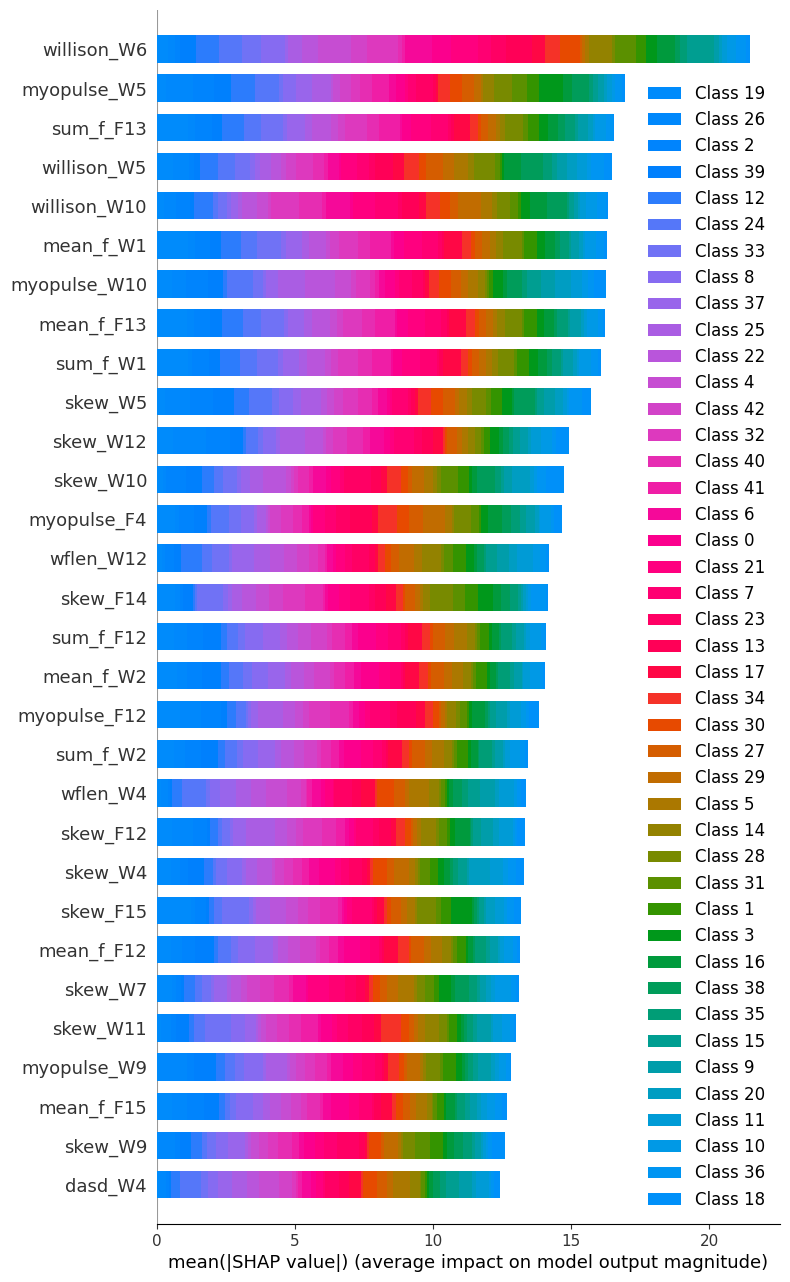

In [30]:
shap.summary_plot(shap_values, feature_names=feature_cols, 
                  max_display=30, 
                  title="Feature importance using Shapley Values (Coloured by class)")

In [31]:
torch.save(model.encoder.state_dict(), 'encoder.pth')

In [50]:
model.encoder.state_dict()

OrderedDict([('l1.weight',
              tensor([[ 0.0214,  0.0310,  0.0475,  ..., -0.0480,  0.0775, -0.0902],
                      [ 0.0153,  0.0246,  0.0507,  ..., -0.0635,  0.0081,  0.1200],
                      [-0.0399, -0.0710, -0.0993,  ..., -0.0042,  0.0826, -0.0109],
                      ...,
                      [ 0.0306, -0.0307, -0.0312,  ..., -0.0523, -0.0194, -0.0106],
                      [ 0.0574, -0.0649, -0.0759,  ...,  0.0178,  0.0269, -0.0098],
                      [-0.0140,  0.0892,  0.0307,  ..., -0.0128,  0.0292, -0.0352]])),
             ('l1.bias',
              tensor([ 0.0628,  0.0411,  0.0132,  0.1067,  0.1643,  0.0495,  0.1280,  0.2120,
                       0.1274,  0.1443,  0.1058,  0.1573,  0.1646,  0.1105,  0.1660,  0.1432,
                       0.1407,  0.1976,  0.0061,  0.1107,  0.0643,  0.1779,  0.0709,  0.1466,
                       0.1187,  0.0822,  0.0408,  0.0405,  0.0656,  0.1375,  0.0302,  0.0495,
                       0.0554,  0.2279

In [48]:
from pickle import dump

In [49]:
dump(scaler, open('scaler.pkl', 'wb'))

## Decision Tree (XGBoost)

In [36]:
import xgboost as xgb
from xgboost import XGBClassifier
import time

In [37]:
cls = XGBClassifier(n_jobs = 6)

In [38]:
start = time.time()
cls.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], early_stopping_rounds=10, verbose=True)
print(f"Time taken:  {time.time() - start}  ")

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-mlogloss:2.00843	validation_1-mlogloss:2.54375
[1]	validation_0-mlogloss:1.49840	validation_1-mlogloss:2.22360
[2]	validation_0-mlogloss:1.17101	validation_1-mlogloss:2.00168
[3]	validation_0-mlogloss:0.93094	validation_1-mlogloss:1.83357
[4]	validation_0-mlogloss:0.74729	validation_1-mlogloss:1.69500
[5]	validation_0-mlogloss:0.60763	validation_1-mlogloss:1.57937
[6]	validation_0-mlogloss:0.49843	validation_1-mlogloss:1.48559
[7]	validation_0-mlogloss:0.40998	validation_1-mlogloss:1.40128
[8]	validation_0-mlogloss:0.34016	validation_1-mlogloss:1.33111
[9]	validation_0-mlogloss:0.28308	validation_1-mlogloss:1.26838
[10]	validation_0-mlogloss:0.23729	validation_1-mlogloss:1.20991
[11]	validation_0-mlogloss:0.19892	validation_1-mlogloss:1.15646
[12]	validation_0-mlogloss:0.16796	validation_1-mlogloss:1.11385
[13]	validation_0-mlogloss:0.14231	validation_1-mlogloss:1.07142
[14]	validation_0-mlogloss:0.12163	validation_1-mlogloss:1.03469
[15]	validation_0-mlogloss:0.10414	

In [41]:
y_pred = cls.predict(x_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.72      0.78        46
           1       0.83      0.89      0.86        44
           2       0.93      1.00      0.97        57
           3       0.87      0.78      0.82        50
           4       0.80      0.85      0.82        46
           5       0.67      0.85      0.75        26
           6       0.88      0.77      0.82        48
           7       0.72      0.91      0.80        43
           8       0.83      0.82      0.83        55
           9       0.91      0.82      0.87        51
          10       0.77      0.85      0.81        47
          11       0.81      0.81      0.81        42
          12       0.89      0.88      0.89        58
          13       0.82      0.86      0.84        42
          14       0.85      0.74      0.79        46
          15       0.78      0.86      0.82        44
          16       0.86      0.84      0.85        50
          17       0.89    

In [43]:
fi_df = pd.DataFrame({ "name": feature_cols, "values": cls.feature_importances_ } )

In [44]:
sorted_f1_df = fi_df.sort_values(by = "values", ascending=False)

Text(0.5, 1.0, 'Feature Imprtance in XGBoost')

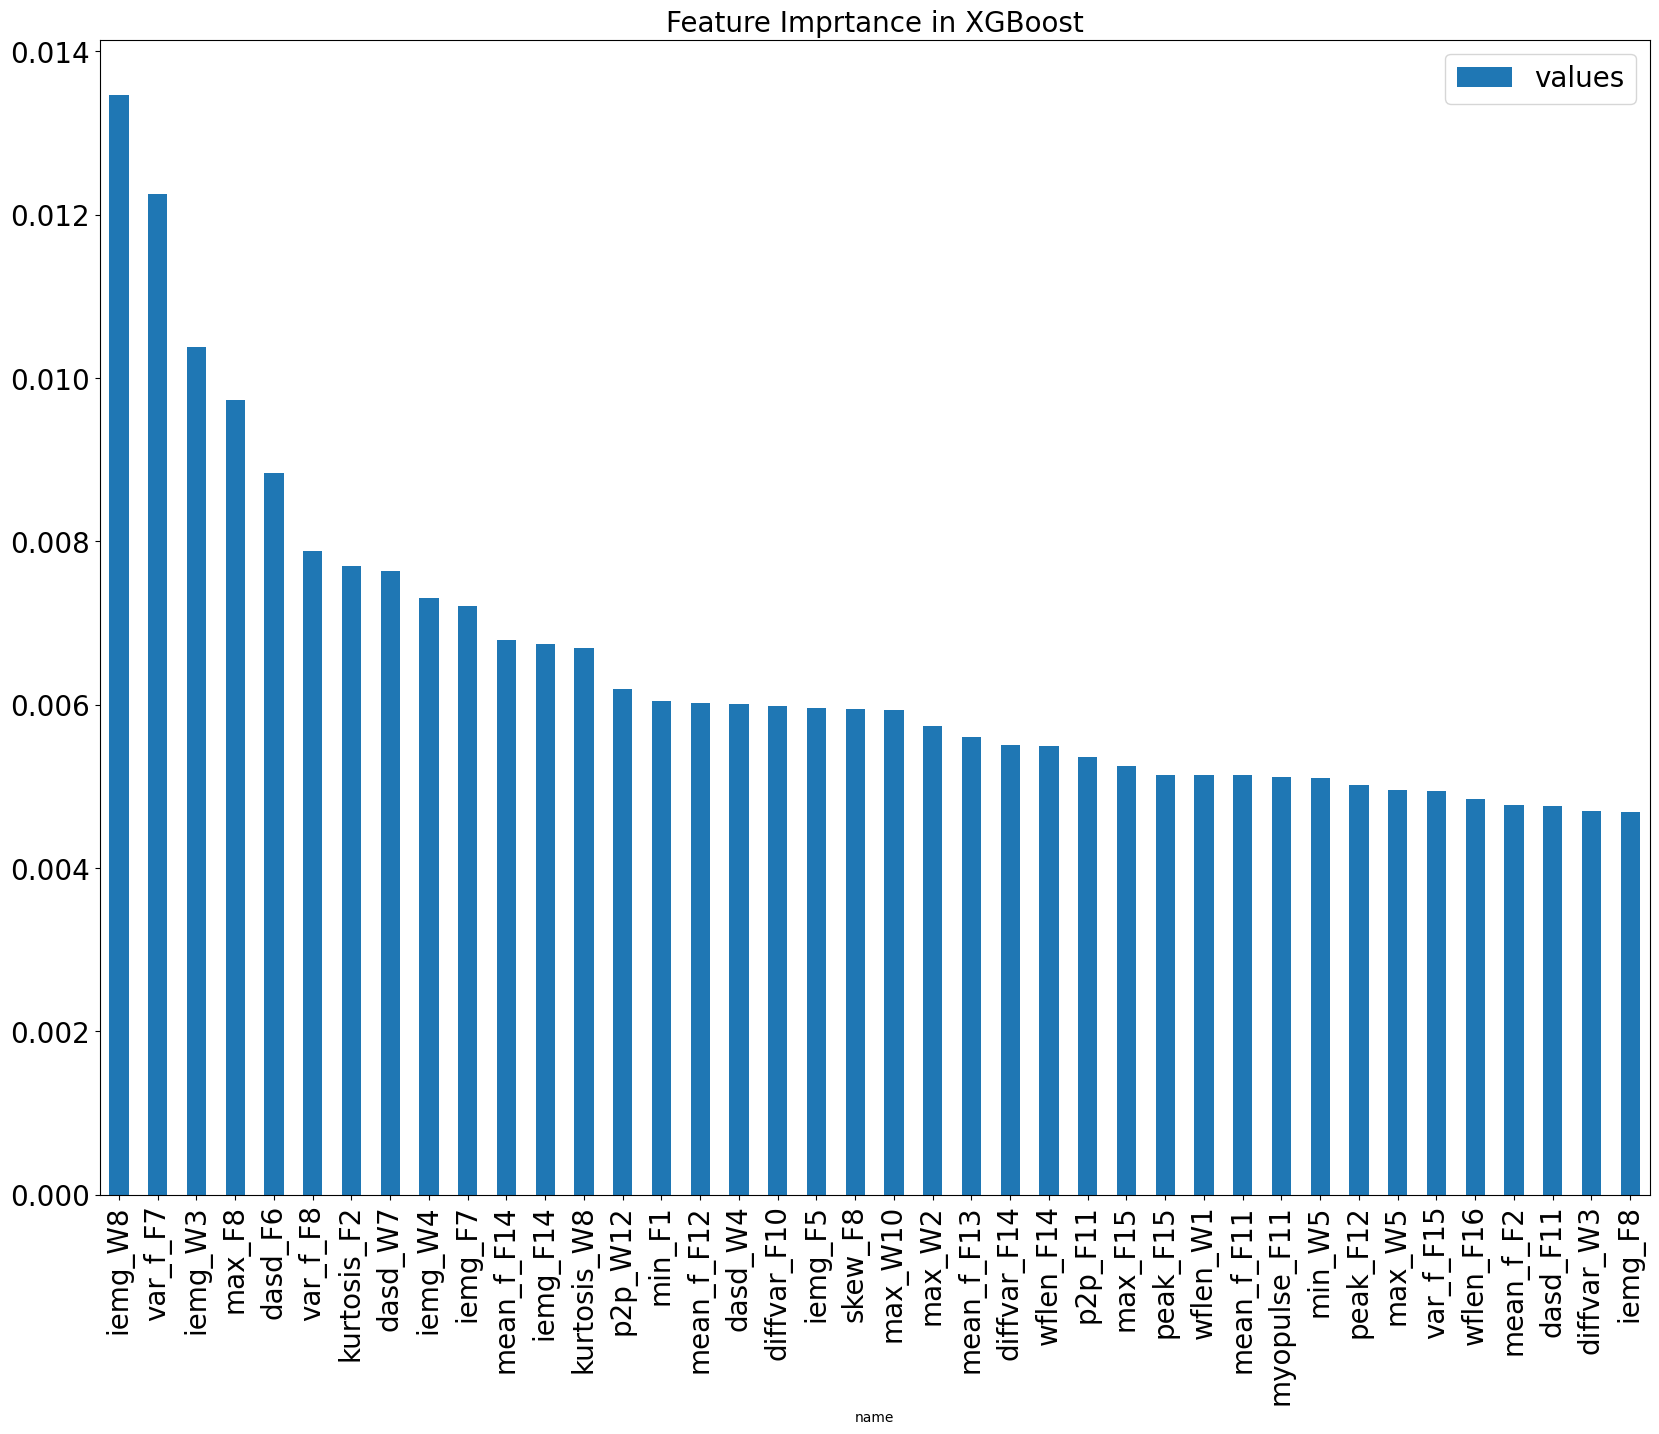

In [47]:

fi_df.sort_values(by = "values", ascending=False)[:40].plot.bar(x = "name", y = "values", figsize = (20,15))
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Feature Imprtance in XGBoost", fontsize=20)